In [1]:
!git clone https://github.com/minjae0501/hand_tracing.git

Cloning into 'hand_tracing'...
remote: Enumerating objects: 3667, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 3667 (delta 1), reused 3 (delta 0), pack-reused 3654
Receiving objects: 100% (3667/3667), 82.42 MiB | 28.08 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:
%pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 52.1 MB/s eta 0:00:00


In [29]:
import os
import mediapipe as mp
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision import transforms
import random

In [30]:
# MediaPipe 손 모델 초기화
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)

# 데이터셋 클래스 정의
class HandDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 이미지 로드 및 랜드마크 검출
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image)

        # 랜드마크 추출 및 전처리
        if results.multi_hand_landmarks:
            landmarks = results.multi_hand_landmarks[0]
            # mediapipe 랜드마크 x, y, z좌표를 가짐 z좌표는 생략
            landmarks = [(lm.x, lm.y, lm.z) for lm in landmarks.landmark]
            landmarks = torch.tensor(landmarks).flatten()

        else:
            landmarks = torch.zeros(63) # 21 * 3 (x, y, z)

        # nn.CrossEntropyLoss는 타켓 라벨로 정수형 텐서를 사용해야 함. -> torch.long
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return landmarks, label

# 신경망 모델 정의
class HandStateNN(nn.Module):
    def __init__(self, n_classes):
        super(HandStateNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(63, 128), # 21 랜드마크 * 3 (x, y, z)
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes),  # n_classes: 분류할 클래스 수
        )

    def forward(self, x):
        return self.fc(x)



In [31]:
# 학습 데이터 경로
image_folder_path = '/content/hand_tracing/data_ver2-2_fullData/train/images'
label_folder_path = '/content/hand_tracing/data_ver2-2_fullData/train/labels'

# 이미지 파일 경로를 가져옵니다.
image_paths = [os.path.join(image_folder_path, img) for img in os.listdir(image_folder_path) if img.endswith('.jpg')]

# 각 이미지에 대응하는 라벨 파일을 읽어옵니다.
labels = []
for img_path in image_paths:
    label_path = os.path.join(label_folder_path, os.path.basename(img_path).replace('.jpg', '.txt'))
    with open(label_path, 'r') as label_file:
        label = float(label_file.read().split()[0])  # 라벨 파일에서 라벨을 읽어옵니다.
        labels.append(label)

dataset = HandDataset(image_paths, labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)



# 검증 데이터 준비
val_image_folder_path = '/content/hand_tracing/data_ver2-2_fullData/val/images'
val_label_folder_path = '/content/hand_tracing/data_ver2-2_fullData/val/labels'

# 이미지 파일 경로를 가져옵니다.
validation_image_paths = [os.path.join(val_image_folder_path, img) for img in os.listdir(val_image_folder_path) if img.endswith('.jpg')]

# 각 이미지에 대응하는 라벨 파일을 읽어옵니다.
validation_labels = []
for img_path in validation_image_paths:
    label_path = os.path.join(val_label_folder_path, os.path.basename(img_path).replace('.jpg', '.txt'))
    with open(label_path, 'r') as label_file:
        label = float(label_file.read().split()[0]) # 라벨 파일에서 라벨을 읽어옵니다.
        validation_labels.append(label)

validation_dataset = HandDataset(validation_image_paths, validation_labels)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)


In [32]:
def delete_all_files_in_folder(folder_path):
    # 폴더 내 모든 파일 목록을 가져옴
    file_list = os.listdir(folder_path)

    # 각 파일에 대해 순회하며 삭제
    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        try:
            if os.path.isfile(file_path):
                # 파일인 경우 삭제
                os.remove(file_path)
            elif os.path.isdir(file_path):
                # 폴더인 경우 재귀적으로 폴더 내 파일 삭제
                delete_all_files_in_folder(file_path)
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")

def random_rotate(image):
    # angle = random.randint(0, 360)  # 0도에서 360도 중 랜덤한 각도 선택
    angle = 180
    return transforms.functional.rotate(image, angle)

# 랜덤한 방향으로 회전된 이미지와 라벨을 데이터셋에 추가
num_rotate_images = int(0.3 * len(image_paths))
rotate_folder = "rotated_images"

# 하위 폴더가 없다면 생성
if not os.path.exists(rotate_folder):
    os.makedirs(rotate_folder)

delete_all_files_in_folder(rotate_folder)

random.seed(42)

for idx in random.sample(range(len(image_paths)), num_rotate_images, random_state= 13):
    image = cv2.imread(image_paths[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rotated_image = random_rotate(transforms.ToTensor()(image))  # 랜덤한 방향으로 회전
    rotated_image = transforms.ToPILImage()(rotated_image)
    rotated_label = dataset[idx][1]  # 라벨 그대로 사용
    dataset.image_paths.append(os.path.join(rotate_folder,f"rotated_image_{idx}.jpg"))  # 이미지 경로 추가
    dataset.labels.append(rotated_label)  # 라벨 추가
    rotated_image.save(os.path.join(rotate_folder,f"rotated_image_{idx}.jpg"))  # 이미지 저장

dataset = HandDataset(image_paths, labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [34]:
# 에폭 수 정의
num_epochs = 20

# 모델 초기화
n_classes = 3 # 분류할 클래스 수
model = HandStateNN(n_classes).to(device)

# 손실 함수 및 최적화기 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train and Val

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-30-a58574261a4e>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx], dtype=torch.long)
  5%|▌         | 1/20 [00:51<16:12, 51.19s/it]

Epoch 0, Validation Loss: 0.7841387490431467


 10%|█         | 2/20 [01:42<15:23, 51.32s/it]

Epoch 1, Validation Loss: 0.8089991236726443


 15%|█▌        | 3/20 [02:33<14:29, 51.12s/it]

Epoch 2, Validation Loss: 0.7571103572845459


 20%|██        | 4/20 [03:25<13:40, 51.29s/it]

Epoch 3, Validation Loss: 0.6483837738633156


 25%|██▌       | 5/20 [04:15<12:47, 51.15s/it]

Epoch 4, Validation Loss: 0.6988715107242266


 30%|███       | 6/20 [05:07<11:57, 51.23s/it]

Epoch 5, Validation Loss: 0.6381170103947321


 35%|███▌      | 7/20 [05:58<11:04, 51.13s/it]

Epoch 6, Validation Loss: 0.7163622577985128


 40%|████      | 8/20 [06:48<10:11, 50.95s/it]

Epoch 7, Validation Loss: 0.601120263338089


 45%|████▌     | 9/20 [07:40<09:21, 51.04s/it]

Epoch 8, Validation Loss: 0.7401791587471962


 50%|█████     | 10/20 [08:31<08:31, 51.12s/it]

Epoch 9, Validation Loss: 0.6081828102469444


 55%|█████▌    | 11/20 [09:22<07:40, 51.13s/it]

Epoch 10, Validation Loss: 0.6709740360577902


 60%|██████    | 12/20 [10:14<06:49, 51.25s/it]

Epoch 11, Validation Loss: 0.6058346927165985


 65%|██████▌   | 13/20 [11:05<05:58, 51.23s/it]

Epoch 12, Validation Loss: 0.7728570873538653


 70%|███████   | 14/20 [11:55<05:06, 51.07s/it]

Epoch 13, Validation Loss: 0.6751030708352724


 75%|███████▌  | 15/20 [12:47<04:15, 51.15s/it]

Epoch 14, Validation Loss: 0.58518335968256


 80%|████████  | 16/20 [13:38<03:24, 51.05s/it]

Epoch 15, Validation Loss: 0.7205021753907204


 85%|████████▌ | 17/20 [14:28<02:32, 50.98s/it]

Epoch 16, Validation Loss: 0.6590907846887907


 90%|█████████ | 18/20 [15:19<01:41, 50.77s/it]

Epoch 17, Validation Loss: 0.5974130406975746


 95%|█████████▌| 19/20 [16:09<00:50, 50.53s/it]

Epoch 18, Validation Loss: 0.6103219812115034


100%|██████████| 20/20 [16:59<00:00, 50.98s/it]

Epoch 19, Validation Loss: 0.5930618246396383


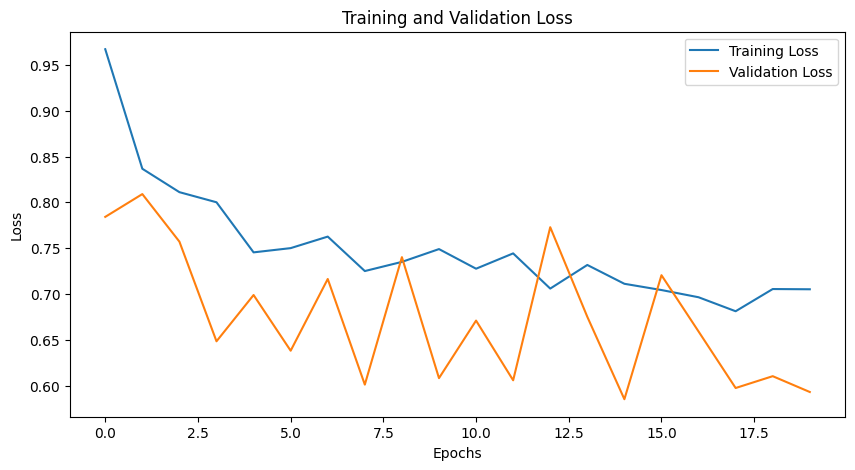

In [35]:
import matplotlib.pyplot as plt

# 학습 및 검증 손실과 정확도를 기록하기 위한 리스트
train_losses = []
validation_losses = []

# 훈련 루프 수정
for epoch in tqdm(range(num_epochs)):
    model.train()  # 훈련 모드
    train_loss = 0.0
    for batch in dataloader:
        landmarks, labels = batch
        landmarks = landmarks.to(device)
        labels = labels.to(device) #라벨을 실수로 변환
        preds = model(landmarks)
        loss = criterion(preds.squeeze(), labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(dataloader)
    train_losses.append(avg_train_loss)

    # 검증 루프
    model.eval()  # 평가 모드
    validation_loss = 0.0
    with torch.no_grad():
        for batch in validation_loader:
            landmarks, labels = batch
            landmarks = landmarks.to(device)
            labels = labels.to(device) #라벨을 실수로 변환
            preds = model(landmarks)
            loss = criterion(preds.squeeze(), labels)
            validation_loss += loss.item()

    avg_validation_loss = validation_loss / len(validation_loader)
    validation_losses.append(avg_validation_loss)

    print(f"Epoch {epoch}, Validation Loss: {avg_validation_loss}")

# 손실 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## 모델저장

In [27]:
save_model_path = './' # 경로 설정

torch.save(model, save_model_path + 'model_regression.pt') # 모델 저장
torch.save(model.state_dict(), save_model_path + 'hand_model_regression.pth') # 모델 객체의 state_dict 저장